In [61]:
#Importar dados diretamente do BigQuery

## Importing Data

In [1]:
#from dataprep.eda import create_report
import pandas as pd

In [7]:
intelipost_data = pd.read_excel(r"C:\Users\rodri\Downloads\intelipost (1).xlsx")

In [8]:
pd.set_option('display.max_columns', 500)


### Visualizing all columns and defining the importants

In [9]:
  intelipost_data.columns

Index(['nome_do_destinatario', 'canal_de_vendas', 'cidade_do_destinatario',
       'uf', 'cep_do_destinatario', 'pedido_de_venda', 'pedido',
       'codigo_de_rastreio', 'serie_nota', 'nota_fiscal', 'metodo_de_envio',
       'transportadora', 'data_despacho', 'status_transportador',
       'data_do_ultimo_status', 'descricao_transportador', 'data_entrega',
       'atualizado_em', 'previsao_entrega_cliente',
       'previsao_entrega_cliente_original', 'situacao', 'performance',
       'previsao_entrega_transp', 'previsao_entrega_transp_original',
       'situacao_transp', 'performance_transp', 'mensagem_intelipost',
       'custo_frete', 'preco_frete', 'no_volumes', 'data_criacao',
       'microstatus', 'status_transp', 'pagina_rastreamento',
       'existem_ocorrencias', 'prazo_transportadora_dias_uteis', 'cep_origem',
       'valor_da_nota', 'praca', 'agendamento', 'inicio_da_janela_agendada',
       'fim_da_janela_agendada', 'tipo_de_entrega', 'entrega_inicial',
       'peso_fisico',

In [16]:
variaveis_interesse = intelipost_data[[
       'uf', 'transportadora', 'data_despacho', 'status_transportador',
       'data_do_ultimo_status',  'data_entrega',
       'atualizado_em', 'previsao_entrega_cliente', 'situacao', 'performance',
       'previsao_entrega_transp', 'previsao_entrega_transp_original',
       'situacao_transp', 'performance_transp', 'data_criacao','prazo_transportadora_dias_uteis',
       'praca','chave_da_nota','quantidade_de_ocorrencias']]

In [11]:
variaveis_interesse['situacao'].value_counts()

No prazo    11190
Atrasado      315
Name: situacao, dtype: int64

### Filter only orders that have already been delivered

In [19]:
base_modelo = variaveis_interesse[variaveis_interesse['data_entrega'].notna()]

In [13]:
base_modelo.head()

,uf,transportadora,data_despacho,status_transportador,data_do_ultimo_status,data_entrega,atualizado_em,previsao_entrega_cliente,situacao,performance,previsao_entrega_transp,previsao_entrega_transp_original,situacao_transp,performance_transp,data_criacao,prazo_transportadora_dias_uteis,praca,chave_da_nota,quantidade_de_ocorrencias
5235,MG,Total,2023-10-02 18:30:3500000 UTC,Entregue,2023-10-09 16:53:0000000 UTC,2023-10-09 16:52:5900000 UTC,2023-10-09 16:54:04.574000 UTC,2023-10-17 23:58:5900000 UTC,No prazo,Entregue no prazo,2023-10-10 23:59:5900000 UTC,2023-10-10 23:59:5900000 UTC,No prazo,Entregue no prazo,2023-10-02 11:34:17.668000 UTC,6.0,Interior,32231027403527000385550010003615231547080454,1.0
5236,SC,Loggi,2023-10-04 17:34:1600000 UTC,Entregue,2023-10-10 13:51:0000000 UTC,2023-10-10 13:50:5900000 UTC,2023-10-10 14:04:30.950000 UTC,2023-10-17 23:58:5900000 UTC,No prazo,Entregue no prazo,2023-10-10 23:59:5900000 UTC,2023-10-10 23:59:5900000 UTC,No prazo,Entregue no prazo,2023-10-04 12:28:35.733000 UTC,4.0,Interior,32231027403527000385550010003636441539962073,1.0
5237,SP,Loggi,2023-10-05 17:40:2600000 UTC,Entregue,2023-10-10 14:49:0000000 UTC,2023-10-10 14:48:5900000 UTC,2023-10-10 14:49:16.954000 UTC,2023-10-17 23:58:5900000 UTC,No prazo,Entregue no prazo,2023-10-10 23:59:5900000 UTC,2023-10-10 23:59:5900000 UTC,No prazo,Entregue no prazo,2023-10-04 17:43:04.400000 UTC,3.0,Capital,32231027403527000385550010003640741291237886,2.0
5238,PR,Loggi,2023-10-05 17:40:2600000 UTC,Entregue,2023-10-11 14:26:0000000 UTC,2023-10-11 14:25:5900000 UTC,2023-10-11 14:26:53.666000 UTC,2023-10-17 23:58:5900000 UTC,No prazo,Entregue no prazo,2023-10-10 23:59:5900000 UTC,2023-10-10 23:59:5900000 UTC,Atrasado,Entregue fora do prazo,2023-10-04 19:32:2512000 UTC,3.0,Capital,32231027403527000385550010003641311786182782,2.0
5239,SC,Loggi,2023-10-05 17:40:2600000 UTC,Entregue,2023-10-13 12:11:0000000 UTC,2023-10-13 12:10:5900000 UTC,2023-10-13 12:11:1498000 UTC,2023-10-17 23:58:5900000 UTC,No prazo,Entregue no prazo,2023-10-10 23:59:5900000 UTC,2023-10-10 23:59:5900000 UTC,Atrasado,Entregue fora do prazo,2023-10-04 23:39:49.860000 UTC,3.0,Capital,32231027403527000385550010003642241313504295,2.0


### Transform the data

In [20]:
def columns_to_date(column):
    base_modelo[column] = pd.to_datetime(base_modelo[column].str.split(" ", expand=True)[0])

In [ ]:
colunas_ajustar_data = ['data_do_ultimo_status','data_entrega','atualizado_em','data_criacao','previsao_entrega_transp',
                        'previsao_entrega_transp_original','previsao_entrega_cliente',
                        'data_despacho']

for column in colunas_ajustar_data:
    columns_to_date(column)

In [ ]:
base_modelo['tempo_dias_despacho'] = (base_modelo['data_despacho'] - base_modelo['data_criacao']).dt.days.astype(int)

In [23]:
dummy_df = pd.get_dummies(base_modelo['transportadora'], prefix='transportadora')
base_modelo = pd.concat([base_modelo, dummy_df], axis=1)
base_modelo.head()

,uf,transportadora,data_despacho,status_transportador,data_do_ultimo_status,data_entrega,atualizado_em,previsao_entrega_cliente,situacao,performance,previsao_entrega_transp,previsao_entrega_transp_original,situacao_transp,performance_transp,data_criacao,prazo_transportadora_dias_uteis,praca,chave_da_nota,quantidade_de_ocorrencias,tempo_dias_despacho,transportadora_Braspress,transportadora_Correios,transportadora_Loggi,transportadora_Total
5235,MG,Total,2023-10-02,Entregue,2023-10-09,2023-10-09,2023-10-09,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-02,6.0,Interior,32231027403527000385550010003615231547080454,1.0,0,0,0,0,1
5236,SC,Loggi,2023-10-04,Entregue,2023-10-10,2023-10-10,2023-10-10,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-04,4.0,Interior,32231027403527000385550010003636441539962073,1.0,0,0,0,1,0
5237,SP,Loggi,2023-10-05,Entregue,2023-10-10,2023-10-10,2023-10-10,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-04,3.0,Capital,32231027403527000385550010003640741291237886,2.0,1,0,0,1,0
5238,PR,Loggi,2023-10-05,Entregue,2023-10-11,2023-10-11,2023-10-11,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,Atrasado,Entregue fora do prazo,2023-10-04,3.0,Capital,32231027403527000385550010003641311786182782,2.0,1,0,0,1,0
5239,SC,Loggi,2023-10-05,Entregue,2023-10-13,2023-10-13,2023-10-13,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,Atrasado,Entregue fora do prazo,2023-10-04,3.0,Capital,32231027403527000385550010003642241313504295,2.0,1,0,0,1,0


In [24]:
base_modelo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4539 entries, 5235 to 11405
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   uf                                4539 non-null   object        
 1   transportadora                    4539 non-null   object        
 2   data_despacho                     4539 non-null   datetime64[ns]
 3   status_transportador              4539 non-null   object        
 4   data_do_ultimo_status             4539 non-null   datetime64[ns]
 5   data_entrega                      4539 non-null   datetime64[ns]
 6   atualizado_em                     4539 non-null   datetime64[ns]
 7   previsao_entrega_cliente          4445 non-null   datetime64[ns]
 8   situacao                          4539 non-null   object        
 9   performance                       4539 non-null   object        
 10  previsao_entrega_transp           4539 non-n

## Transform states in regions

In [150]:
state_to_region = {
    'AC': 'Norte',
    'AL': 'Nordeste',
    'AP': 'Norte',
    'AM': 'Norte',
    'BA': 'Nordeste',
    'CE': 'Nordeste',
    'DF': 'Centro-Oeste',
    'ES': 'Sudeste',
    'GO': 'Centro-Oeste',
    'MA': 'Nordeste',
    'MT': 'Centro-Oeste',
    'MS': 'Centro-Oeste',
    'MG': 'Sudeste',
    'PA': 'Norte',
    'PB': 'Nordeste',
    'PR': 'Sul',
    'PE': 'Nordeste',
    'PI': 'Nordeste',
    'RJ': 'Sudeste',
    'RN': 'Nordeste',
    'RS': 'Sul',
    'RO': 'Norte',
    'RR': 'Norte',
    'SC': 'Sul',
    'SP': 'Sudeste',
    'SE': 'Nordeste',
    'TO': 'Norte',
}
base_modelo['region'] = base_modelo['uf'].map(state_to_region)

In [151]:
dummy_df = pd.get_dummies(base_modelo['region'], prefix='regiao',drop_first=True)
base_modelo = pd.concat([base_modelo, dummy_df], axis=1)
base_modelo.head()

,uf,transportadora,data_despacho,status_transportador,data_do_ultimo_status,data_entrega,atualizado_em,previsao_entrega_cliente,previsao_entrega_cliente_original,situacao,performance,previsao_entrega_transp,previsao_entrega_transp_original,situacao_transp,performance_transp,data_criacao,prazo_transportadora_dias_uteis,praca,chave_da_nota,quantidade_de_ocorrencias,tempo_dias_despacho,transportadora_Braspress,transportadora_Correios,transportadora_Loggi,transportadora_Total,region,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul
5235,MG,Total,2023-10-02,Entregue,2023-10-09,2023-10-09,2023-10-09,2023-10-17,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-02,6.0,Interior,32231027403527000385550010003615231547080454,1.0,0,0,0,0,1,Sudeste,0,0,1,0
5236,SC,Loggi,2023-10-04,Entregue,2023-10-10,2023-10-10,2023-10-10,2023-10-17,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-04,4.0,Interior,32231027403527000385550010003636441539962073,1.0,0,0,0,1,0,Sul,0,0,0,1
5237,SP,Loggi,2023-10-05,Entregue,2023-10-10,2023-10-10,2023-10-10,2023-10-17,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-04,3.0,Capital,32231027403527000385550010003640741291237886,2.0,1,0,0,1,0,Sudeste,0,0,1,0
5238,PR,Loggi,2023-10-05,Entregue,2023-10-11,2023-10-11,2023-10-11,2023-10-17,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,Atrasado,Entregue fora do prazo,2023-10-04,3.0,Capital,32231027403527000385550010003641311786182782,2.0,1,0,0,1,0,Sul,0,0,0,1
5239,SC,Loggi,2023-10-05,Entregue,2023-10-13,2023-10-13,2023-10-13,2023-10-17,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,Atrasado,Entregue fora do prazo,2023-10-04,3.0,Capital,32231027403527000385550010003642241313504295,2.0,1,0,0,1,0,Sul,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,DF,Total,2023-11-13,Entregue,2023-11-16,2023-11-16,2023-11-16,2023-11-19,2023-11-19,No prazo,Entregue no prazo,2023-11-20,2023-11-20,No prazo,Entregue no prazo,2023-11-08,4.0,Capital,32231127403527000385550010004536561478619602,0.0,5,0,0,0,1,Centro-Oeste,0,0,0,0
11369,SP,Total,2023-11-13,Entregue,2023-11-15,2023-11-15,2023-11-15,2023-11-19,2023-11-19,No prazo,Entregue no prazo,2023-11-20,2023-11-20,No prazo,Entregue no prazo,2023-11-08,4.0,Interior,32231127403527000385550010004537451036321294,0.0,5,0,0,0,1,Sudeste,0,0,1,0
11380,SP,Total,2023-11-13,Entregue,2023-11-15,2023-11-15,2023-11-15,2023-11-19,2023-11-19,No prazo,Entregue no prazo,2023-11-20,2023-11-20,No prazo,Entregue no prazo,2023-11-08,4.0,Interior,32231127403527000385550010004538061140209575,0.0,5,0,0,0,1,Sudeste,0,0,1,0
11382,DF,Total,2023-11-13,Entregue,2023-11-16,2023-11-16,2023-11-16,2023-11-19,2023-11-19,No prazo,Entregue no prazo,2023-11-20,2023-11-20,No prazo,Entregue no prazo,2023-11-08,4.0,Capital,32231127403527000385550010004538991530840570,0.0,5,0,0,0,1,Centro-Oeste,0,0,0,0


In [60]:
#exportar para pegar apenas as chaves para tratar fora. Posteriormente ajustar para pegar dentro do código
base_modelo['chave_da_nota'].to_excel(r"C:\Users\rodri\Downloads\test.xlsx",index = False)

## Tempo de faturamento

In [27]:
df_faturamento = pd.read_excel(r"C:\Users\rodri\Downloads\test.xlsx")

In [28]:
df_faturamento.head()

,data_emiss,data_inici,tempo_faturamento,chave_nota,data_shopify,tempo_integracao
0,2023-10-01,2023-10-01,0,32231027403527000385550010003607391945488689,2023-10-01,0
1,2023-10-01,2023-10-01,0,32231027403527000385550010003607401005317179,2023-10-01,0
2,2023-10-01,2023-10-01,0,32231027403527000385550010003607431746198306,2023-10-01,0
3,2023-10-01,2023-10-01,0,32231027403527000385550010003607451345235248,2023-10-01,0
4,2023-10-01,2023-10-01,0,32231027403527000385550010003607481568421531,2023-10-01,0


In [30]:
base_modelo.head()

,uf,transportadora,data_despacho,status_transportador,data_do_ultimo_status,data_entrega,atualizado_em,previsao_entrega_cliente,situacao,performance,previsao_entrega_transp,previsao_entrega_transp_original,situacao_transp,performance_transp,data_criacao,prazo_transportadora_dias_uteis,praca,chave_da_nota,quantidade_de_ocorrencias,tempo_dias_despacho,transportadora_Braspress,transportadora_Correios,transportadora_Loggi,transportadora_Total,data_emiss,data_inici,tempo_faturamento,chave_nota,data_shopify,tempo_integracao
0,MG,Total,2023-10-02,Entregue,2023-10-09,2023-10-09,2023-10-09,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-02,6.0,Interior,32231027403527000385550010003615231547080454,1.0,0,0,0,0,1,2023-10-02,2023-10-02,0,32231027403527000385550010003615231547080454,2023-10-02,0
1,SC,Loggi,2023-10-04,Entregue,2023-10-10,2023-10-10,2023-10-10,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-04,4.0,Interior,32231027403527000385550010003636441539962073,1.0,0,0,0,1,0,2023-10-04,2023-10-04,0,32231027403527000385550010003636441539962073,2023-10-04,0
2,SP,Loggi,2023-10-05,Entregue,2023-10-10,2023-10-10,2023-10-10,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,No prazo,Entregue no prazo,2023-10-04,3.0,Capital,32231027403527000385550010003640741291237886,2.0,1,0,0,1,0,2023-10-04,2023-10-04,0,32231027403527000385550010003640741291237886,2023-10-04,0
3,PR,Loggi,2023-10-05,Entregue,2023-10-11,2023-10-11,2023-10-11,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,Atrasado,Entregue fora do prazo,2023-10-04,3.0,Capital,32231027403527000385550010003641311786182782,2.0,1,0,0,1,0,2023-10-04,2023-10-04,0,32231027403527000385550010003641311786182782,2023-10-04,0
4,SC,Loggi,2023-10-05,Entregue,2023-10-13,2023-10-13,2023-10-13,2023-10-17,No prazo,Entregue no prazo,2023-10-10,2023-10-10,Atrasado,Entregue fora do prazo,2023-10-04,3.0,Capital,32231027403527000385550010003642241313504295,2.0,1,0,0,1,0,2023-10-04,2023-10-04,0,32231027403527000385550010003642241313504295,2023-10-04,0


In [29]:
base_modelo = base_modelo.merge(
    df_faturamento, 
    left_on = 'chave_da_nota', right_on = 'chave_nota', 
    how = 'left'
)

# Tempo integração até despacho

In [34]:
base_modelo['tempo_total_despacho'] = (base_modelo['data_despacho'] - base_modelo['data_shopify']).dt.days.astype(int)

In [39]:
base_modelo['tempo_total_despacho'].describe()

count    4539.000000
mean        1.634501
std         1.466133
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        14.000000
Name: tempo_total_despacho, dtype: float64

In [ ]:
### CRIAR UM GROUP BY PARA COMPARAR AS MEDIDAS DESCRITIVAS POR TIPO DE ENTREGA!

## Mudar as variáveis para binárias -> fora do prazo e praça

In [40]:
mapeamento = {
    "Entregue no prazo": 0, "Entregue fora do prazo": 1,
    "Capital":1, "Interior":0,}


In [41]:
base_modelo[['performance','praca','performance_transp']] = base_modelo[['performance','praca','performance_transp']].replace(mapeamento)

In [42]:
base_modelo.head()

,uf,transportadora,data_despacho,status_transportador,data_do_ultimo_status,data_entrega,atualizado_em,previsao_entrega_cliente,situacao,performance,previsao_entrega_transp,previsao_entrega_transp_original,situacao_transp,performance_transp,data_criacao,prazo_transportadora_dias_uteis,praca,chave_da_nota,quantidade_de_ocorrencias,tempo_dias_despacho,transportadora_Braspress,transportadora_Correios,transportadora_Loggi,transportadora_Total,data_emiss,data_inici,tempo_faturamento,chave_nota,data_shopify,tempo_integracao,tempo_total_despacho
0,MG,Total,2023-10-02,Entregue,2023-10-09,2023-10-09,2023-10-09,2023-10-17,No prazo,0,2023-10-10,2023-10-10,No prazo,0,2023-10-02,6.0,0,32231027403527000385550010003615231547080454,1.0,0,0,0,0,1,2023-10-02,2023-10-02,0,32231027403527000385550010003615231547080454,2023-10-02,0,0
1,SC,Loggi,2023-10-04,Entregue,2023-10-10,2023-10-10,2023-10-10,2023-10-17,No prazo,0,2023-10-10,2023-10-10,No prazo,0,2023-10-04,4.0,0,32231027403527000385550010003636441539962073,1.0,0,0,0,1,0,2023-10-04,2023-10-04,0,32231027403527000385550010003636441539962073,2023-10-04,0,0
2,SP,Loggi,2023-10-05,Entregue,2023-10-10,2023-10-10,2023-10-10,2023-10-17,No prazo,0,2023-10-10,2023-10-10,No prazo,0,2023-10-04,3.0,1,32231027403527000385550010003640741291237886,2.0,1,0,0,1,0,2023-10-04,2023-10-04,0,32231027403527000385550010003640741291237886,2023-10-04,0,1
3,PR,Loggi,2023-10-05,Entregue,2023-10-11,2023-10-11,2023-10-11,2023-10-17,No prazo,0,2023-10-10,2023-10-10,Atrasado,1,2023-10-04,3.0,1,32231027403527000385550010003641311786182782,2.0,1,0,0,1,0,2023-10-04,2023-10-04,0,32231027403527000385550010003641311786182782,2023-10-04,0,1
4,SC,Loggi,2023-10-05,Entregue,2023-10-13,2023-10-13,2023-10-13,2023-10-17,No prazo,0,2023-10-10,2023-10-10,Atrasado,1,2023-10-04,3.0,1,32231027403527000385550010003642241313504295,2.0,1,0,0,1,0,2023-10-04,2023-10-04,0,32231027403527000385550010003642241313504295,2023-10-04,0,1


### Definindo Variáveis X e Y

In [53]:
y = base_modelo['performance']
X = base_modelo[['prazo_transportadora_dias_uteis','praca','tempo_total_despacho','quantidade_de_ocorrencias',
                 'transportadora_Braspress','transportadora_Correios','transportadora_Loggi','transportadora_Total']]

### Separando em base e treino

In [56]:
#Regressão Logística

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

logistic_regression = LogisticRegression(class_weight='balanced')
logistic_regression.fit(X_train,y_train)
ypred = logistic_regression.predict(X_test)

In [57]:
acuracia = metrics.accuracy_score(y_test,ypred)
log_loss = metrics.log_loss(y_test,ypred)
roc_auc = metrics.roc_auc_score(y_test,ypred)
classification = metrics.classification_report(y_test, ypred)
cm = metrics.confusion_matrix(y_test, ypred)


print(f"variaveis independentes: {X.columns}\n")
print(f"Acurácia: {acuracia}\n")
print(f"Log loss: {log_loss}\n")
print(f"Curva Roc: {roc_auc}\n")
print(f"Classification Report")
print(classification)
print(f"matriz de confusão:")
print(cm)


variaveis independentes: Index(['prazo_transportadora_dias_uteis', 'praca', 'tempo_total_despacho',
       'quantidade_de_ocorrencias', 'transportadora_Braspress',
       'transportadora_Correios', 'transportadora_Loggi',
       'transportadora_Total'],
      dtype='object')

Acurácia: 0.7859030837004405

Log loss: 7.394804733905305

Curva Roc: 0.753217054263566

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      1075
           1       0.16      0.72      0.26        60

    accuracy                           0.79      1135
   macro avg       0.57      0.75      0.57      1135
weighted avg       0.94      0.79      0.84      1135

matriz de confusão:
[[849 226]
 [ 17  43]]


### Ploting  Confusion Matrix

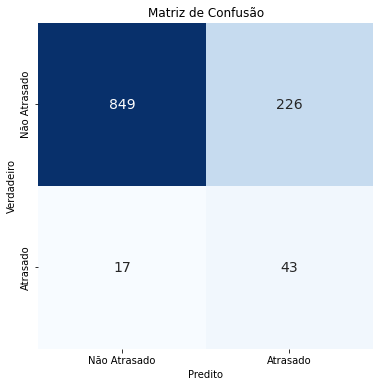

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 14}, xticklabels=["Não Atrasado", "Atrasado"],
            yticklabels=["Não Atrasado", "Atrasado"])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

### Backlog

In [50]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

# Example with class_weight parameter
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train,y_train)
ypred = model.predict(X_test)